In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
import copy
import os
import sys
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.ast_utils import load_games_from_file
from src.fitness_energy_utils import NON_FEATURE_COLUMNS


In [15]:
fitness_df = utils.load_fitness_data()
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,mean_depth_setup,mean_depth_constraints,mean_depth_terminal,mean_depth_scoring,node_count_setup,node_count_constraints,node_count_terminal,node_count_scoring,real,original_game_name
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1.0,1.0,1.0,1.00,1.0,0.5,...,6.083333,9.091954,2.6,1.500000,24,87,10,4,True,6172feb1665491d1efbce164-0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1.0,1.0,1.0,1.00,1.0,1.0,...,3.454545,9.301075,2.6,4.921053,11,93,10,38,True,5f77754ba932fb2c4ba181d8-2
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1.0,1.0,1.0,0.00,1.0,0.0,...,0.000000,5.947368,0.0,2.500000,0,19,0,6,True,614b603d4da88384282967a7-3
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1.0,1.0,1.0,0.00,1.0,1.0,...,0.000000,9.771930,0.0,1.500000,0,57,0,4,True,5bc79f652885710001a0e82a-5
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1.0,1.0,1.0,0.25,1.0,1.0,...,5.638889,10.227273,0.0,4.531250,36,110,0,32,True,614dec67f6eb129c3a77defd-6


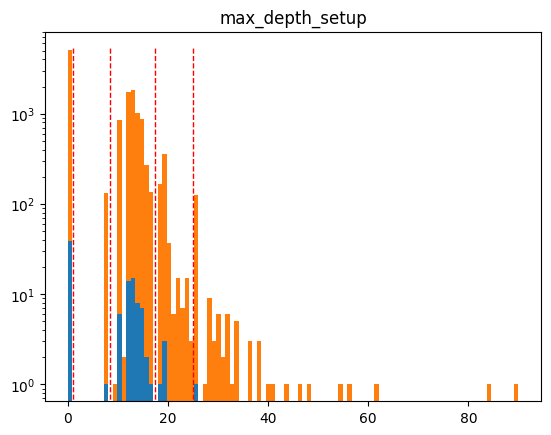

0.0     0.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4     6.4
0.5    12.0
0.6    12.0
0.7    13.0
0.8    14.0
0.9    15.0
1.0    26.0
Name: max_depth_setup, dtype: float64
0.0     0.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4    -1.6
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9     0.0
1.0   -64.0
Name: max_depth_setup, dtype: float64


In [111]:
def plot_with_thresholds(key: str, thresholds: typing.Optional[typing.List[float]] = None):
    hist_data = [fitness_df.loc[fitness_df.src_file == src_file, key] for src_file in fitness_df.src_file.unique()]
    plt.hist(hist_data, histtype='bar', stacked=True, bins=100)
    if thresholds is not None:
        plt.vlines(thresholds, *plt.ylim(), colors='r', linewidths=1, linestyles='dashed')
    plt.yscale('log')
    plt.title(key)
    plt.show()

    q = fitness_df.groupby('src_file')[key].quantile(np.linspace(0, 1, 11))
    print(q['interactive-beta.pddl'])
    print(q['interactive-beta.pddl'] - q['ast-real-regrowth-samples.pddl'])

plot_with_thresholds('max_depth_setup', [1, 8.5, 17.5, 25.5])
# plot_with_thresholds('max_depth_constraints', [8.5, 15.5, 19.5, 23.5])
# plot_with_thresholds('max_depth_terminal', [1, 4.5, 8.5, 11.5])
# plot_with_thresholds('max_depth_scoring', [2.5, 4.5, 8.5, 12.5])

# plot_with_thresholds('mean_depth_setup', [1, 4, 9, 12]) 
# plot_with_thresholds('mean_depth_constraints', [6.5, 8, 10, 12]) 
# plot_with_thresholds('mean_depth_terminal', [1, 2, 3.8, 5.5]) 
# plot_with_thresholds('mean_depth_scoring', [1.5, 2.75, 4, 6]) 

# plot_with_thresholds('node_count_setup', [1, 10, 30, 100])   
# plot_with_thresholds('node_count_constraints', [30, 70, 135, 200])  
# plot_with_thresholds('node_count_terminal', [1, 5, 25, 55])  
# plot_with_thresholds('node_count_scoring', [6, 18, 33, 60])  

In [5]:
for column in fitness_df.columns:
    if column not in utils.NON_FEATURE_COLUMNS:
        indices = np.argwhere((fitness_df.loc[fitness_df.real, column] != 1).values)
        if len(indices) > 0:
            print(column, fitness_df.iloc[indices.reshape(-1), 2].values)

setup_objects_used ['614b603d4da88384282967a7-3' '5bc79f652885710001a0e82a-5'
 '614dec67f6eb129c3a77defd-6' '615b40bb6cdb0f1f6f291f45-8'
 '57aa430b4cda6e00018420e9-10' '5d29412ab711e9001ab74ece-11'
 '609c15fd6888b88a23312c4-14' '5f5d6c3cbacc025bf0a03440-15'
 '616e4f7a16145200573161a6-16' '613e4bf960ca68f8de00e5e7-17'
 '5e2df2855e01ef3e5d01ab58-20' '60d432ce6e413e7509dd4b78-22'
 '61267978e96853d3b974ca53-23' '5996d2256b939900012d9f22-24'
 '5bb511c6689fc5000149c703-29' '5b8c8e7d0c740e00019d55c3-31'
 '56cb8858edf8da000b6df354-32' '615dd68523c38ecff40b29b4-35'
 '5ef4c07dc8437809ba661613-36' '5fa45dc96da3af0b7dcba9a8-37'
 '616abb33ebe1d6112545f76d-38' '614fb15adc48d3f9ffcadd41-39'
 '5f8d77f0b348950659f1919e-41' '5edc195a95d5090e1c3f91b-42'
 '60e7044ddc2523fab6cbc0cd-45' '5d470786da637a00014ba26f-47'
 '5ff4a242cbe069bc27d9278b-51' '602d84f17cdd707e9caed37a-52'
 '5f0cc31363e0816c1b0db7e1-53' '61541833a06877a656163b10-54'
 '604a7e9f84bf0e7937200df5-56' '61623853a4ccad551beeb11a-57'
 '5f0a5a99d

In [14]:
fake_games = fitness_df[fitness_df.src_file == 'ast-real-regrowth-samples.pddl'].reset_index(drop=True)
broadcasted_original = fitness_df.loc[[fitness_df.index[(fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index(drop=True)

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

# fig, axes = plt.subplots(2, 5, figsize=(20, 10))
# index = 0
# for column in original_regrown_diffs.columns:
#     if column in ('index', 'Index', 'real'):
#         continue

#     ax = axes[index // 5][index % 5]
#     ax.hist(original_regrown_diffs[column], bins=20)
#     ax.set_title(f'{column} diff real minus regrown')
#     index += 1

# plt.show()
unchanged_games_prop = (original_regrown_diffs == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In 11.42% of the games, the regrown game was identical to the original game.


Text(0.5, 1.0, 'Number of fitness feature changes in regrown games')

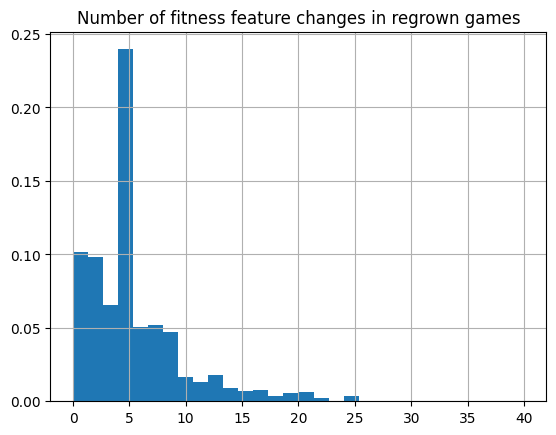

In [24]:
regrowth_changes = (original_regrown_diffs != 0).sum(axis=1)
ax = regrowth_changes.hist(bins=30, density=True)
ax.set_title('Number of fitness feature changes in regrown games')

In [30]:
(original_regrown_diffs != 0).sum(axis=0).sort_values(ascending=False).head(20)

mean_depth_constraints                 664
node_count_constraints                 653
correct_predicate_arity                529
pred_arg_types_agent_holds_balls       351
pred_arg_types_in_motion_balls         320
all_preferences_used                   306
no_variable_twice_in_predicate         283
variable_not_repeated                  280
pref_forall_correct                    256
all_variables_used                     245
max_depth_constraints                  240
setup_objects_used                     182
node_count_scoring                     167
mean_depth_scoring                     167
pred_arg_types_in_receptacles_balls    163
mean_depth_setup                       143
compositionality_structure_1           142
no_nested_logicals                     142
node_count_setup                       141
compositionality_structure_0           126
dtype: int64

In [45]:
(original_regrown_diffs[(original_regrown_diffs != 0).sum(axis=1) == 5] != 0).sum(axis=0).sort_values(ascending=False).head(20)

pref_forall_correct                 141
all_preferences_used                141
node_count_constraints              118
mean_depth_constraints              118
mean_depth_scoring                   99
node_count_scoring                   99
max_depth_scoring                    98
correct_predicate_arity              67
pred_arg_types_agent_holds_balls     41
node_count_terminal                  36
mean_depth_terminal                  36
max_depth_terminal                   36
pred_arg_types_in_motion_balls       36
all_variables_used                   35
setup_objects_used                   34
node_count_setup                     28
mean_depth_setup                     28
all_variables_defined                24
compositionality_structure_1         16
compositionality_structure_0         14
dtype: int64

In [ ]:
real_games = fitness_df[fitness_df.src_file == 'ast-mle-samples.pddl']
fake_games = fitness_df[fitness_df.src_file == 'ast-mle-regrowth-samples.pddl'].reset_index()

for i, real_game_row in real_games.iterrows():
    game_row = real_game_row.drop(NON_FEATURE_COLUMNS)
    game_name = real_game_row.game_name
    game_fakes = fake_games[fake_games.original_game_name == game_name].drop(NON_FEATURE_COLUMNS, axis=1)
    game_fakes.align(game_row, axis=1, copy=False)
    same_indices = fake_games[fake_games.original_game_name == game_name].index[(game_fakes == game_row).all(axis=1)]
    if same_indices.any():
        print(game_name, same_indices)
    

# Kernel Density Experiments

In [41]:
KDE_PARAM_GRID = [
    {
        'kde__kernel': ['gaussian', 'exponential', ], #   'cosine', 'tophat', 'epanechnikov', 'linear',
        'kde__bandwidth': [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 2.5, 5.0, 10],
        'pca__n_components': [20, 40, 60],
    },
    # {
    #     'kde__kernel': ['gaussian', 'exponential', 'cosine', 'tophat', 'epanechnikov', 'linear',], #  
    #     'kde__bandwidth': [0.01, 0.05],
    # },
]
RANDOM_SEED = 33


def cross_validate_kde(train: np.ndarray,
    param_grid: typing.Dict[str, typing.Any],
    n_folds: int = 5, random_seed: int = RANDOM_SEED,
):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('kde', KernelDensity())])
    cv = GridSearchCV(pipeline, param_grid, cv=KFold(n_folds, shuffle=True, random_state=random_seed), n_jobs=-1, verbose=0)
    cv.fit(train, None)
    return cv


def repeated_cross_validate_kde(data_df: pd.DataFrame, n_repeats: int = 5,
    param_grid: typing.Dict[str, typing.Any] = KDE_PARAM_GRID,
    random_seed: int = RANDOM_SEED):
    real_games_df = data_df[data_df.src_file == 'interactive-beta.pddl'].drop(NON_FEATURE_COLUMNS, axis=1)

    for i in range(n_repeats):
        seed = random_seed + i
        print(f'Cross validation repeat {i + 1}/{n_repeats}')
        train, test = train_test_split(real_games_df.values, test_size=0.2, random_state=seed)
        cv = cross_validate_kde(train, param_grid, random_seed=seed)
        print(f'Best params: {cv.best_params_}')
        print(f'Best score: {cv.best_score_}')
        best_model = cv.best_estimator_.named_steps['kde']  # type: ignore
        print(f'Best model score on test set: {cv.best_estimator_.score(test, None)}')

    
repeated_cross_validate_kde(fitness_df)



Cross validation repeat 1/5
Best params: {'kde__bandwidth': 0.25, 'kde__kernel': 'exponential', 'pca__n_components': 20}
Best score: -481.36660887553865
Best model score on test set: -625.9081185535086
Cross validation repeat 2/5
Best params: {'kde__bandwidth': 0.25, 'kde__kernel': 'exponential', 'pca__n_components': 20}
Best score: -476.4805188879792
Best model score on test set: -708.5381252271925
Cross validation repeat 3/5
Best params: {'kde__bandwidth': 0.25, 'kde__kernel': 'exponential', 'pca__n_components': 20}
Best score: -477.9308859453357
Best model score on test set: -588.9915880651344
Cross validation repeat 4/5
Best params: {'kde__bandwidth': 0.25, 'kde__kernel': 'exponential', 'pca__n_components': 20}
Best score: -494.0627965040447
Best model score on test set: -627.4180138736269
Cross validation repeat 5/5
Best params: {'kde__bandwidth': 0.25, 'kde__kernel': 'exponential', 'pca__n_components': 20}
Best score: -484.1162406592349
Best model score on test set: -643.50566982

In [42]:
real_games_df = fitness_df[fitness_df.src_file == 'interactive-beta.pddl'].drop(NON_FEATURE_COLUMNS, axis=1)

kde_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=20)), 
    ('kde', KernelDensity(kernel='exponential', bandwidth=0.25))
])

kde_pipeline.fit(real_games_df.values, None)
real_scores = kde_pipeline.score_samples(real_games_df.values)

In [45]:
n = 20
mle_large_games_df = fitness_df[fitness_df.src_file == 'ast-mle-samples-large.pddl'].drop(NON_FEATURE_COLUMNS, axis=1)

mle_scores = kde_pipeline.score_samples(mle_large_games_df.values)
# mle_smallest_idx = np.argpartition(mle_scores, -n)[-n:]
# mle_scores[mle_smallest_idx]

(array([94.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([-15.537583  , -15.42521226, -15.31284151, -15.20047077,
        -15.08810003, -14.97572928, -14.86335854, -14.7509878 ,
        -14.63861705, -14.52624631, -14.41387556]),
 <BarContainer object of 10 artists>)

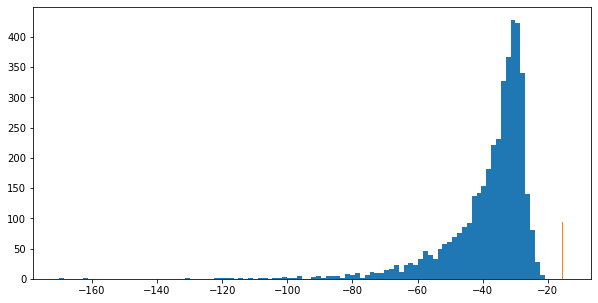

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(mle_scores, bins=100)
ax.hist(real_scores)

In [47]:
n = 200
mle_scores = kde_pipeline.score_samples(mle_large_games_df.values)
mle_smallest_idx = np.argpartition(mle_scores, -n)[-n:]
mle_scores[mle_smallest_idx].min()

-26.57737752660762

In [48]:
sorted_smallest_idxs = np.sort(mle_smallest_idx)
best_random_games_df = fitness_df[fitness_df.src_file == 'ast-mle-samples-large.pddl'].iloc[sorted_smallest_idxs]

# best_random_scores = kde_pipeline.score_samples(best_random_games_df.drop(NON_FEATURE_COLUMNS, axis=1).values)
# plt.hist(best_random_scores)
best_random_game_names = set(best_random_games_df.game_name.unique())
best_random_games_df.head()

,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,mean_depth_setup,mean_depth_constraints,mean_depth_terminal,mean_depth_scoring,node_count_setup,node_count_constraints,node_count_terminal,node_count_scoring,real,original_game_name
6054,6054,ast-mle-samples-large.pddl,game-id-36,medium-objects-room-v1,1.0,0.400000,0.5,0.250000,0.5,0.5,...,8.022727,9.560440,1.571429,2.000,44,91,7,5,False,game-id
6061,6061,ast-mle-samples-large.pddl,game-id-43,many-objects-room-v1,1.0,0.400000,0.5,0.000000,1.0,0.0,...,6.066667,7.128571,3.357143,2.000,30,70,14,5,False,game-id
6076,6076,ast-mle-samples-large.pddl,game-id-58,few-objects-room-v1,1.0,0.363636,0.5,0.333333,1.0,0.5,...,9.000000,7.608696,4.904762,3.875,40,69,21,16,False,game-id
6082,6082,ast-mle-samples-large.pddl,game-id-64,many-objects-room-v1,1.0,0.500000,1.0,0.250000,1.0,1.0,...,11.217391,7.848485,4.058824,0.000,69,33,17,1,False,game-id
6083,6083,ast-mle-samples-large.pddl,game-id-65,many-objects-room-v1,0.0,0.000000,1.0,0.000000,1.0,0.0,...,2.500000,3.500000,1.571429,4.500,8,8,7,16,False,game-id


In [49]:
start_index = len('(define (game ')
best_game_texts = []

for text_game in load_games_from_file('../dsl/ast-mle-samples-large.pddl'):
    text_game = text_game.strip()
    game_name = text_game[start_index:text_game.find(')', start_index)]
    if game_name in best_random_game_names:
        best_game_texts.append(text_game)

with open('../dsl/ast-mle-samples-large-best.pddl', 'w') as f:
    f.write('\n'.join(best_game_texts))

# Approach
* In each batch, sample some number of real games, and for each of them, subsample some number of the corrupted games.
* Learn a regressor to the fitness (maybe with a hidden layer?)
* Try different regularization approaches/strengths (L1, L2, both)
* Evaluate on held-out validation set, see that it doesn't collapse

## Loss function
I'm inspired by the way Chris Dyer (in https://arxiv.org/abs/1410.8251) writes down the NCE loss:
$$ \mathcal{L}_{NCE_k}^{MC} = \sum_{(w,c) \in \mathcal{D}} \left( \log p (D = 1 \mid c, w) - \sum_{i=1, \bar{w} \sim q}^k \log p (D = 0 \mid c, \bar{w}) \right) $$
where: 
* $\mathcal{D}$ is the dataset comprised of pairs $(c, w)$ of context and the correct continuation $w$
* $D$ is the label, where $D = 1$ indicates true data and $D = $ indicates noise
* $q$ is a noise proposal distribution from which to sample $\bar{w}$, the noise foil examples for the current context.

In our case: 
* I think of the context $c$ as some game id, where the correct production $w$ is the true game
* Tha labels $D$ behave as they do above, $D = 1$ for a correct game and $D = 0$ for an incorrect one. 
* Our regrowth sampler is the proposal distribution $q$ (from which we could eventually generate as many samples as we want, but currently I pre-generate some number of samples per game).
* Given that my fitness model produces a single output, which I currently pass through a sigmoid, we can think about it as outputting $P(D = 1 \mid c, w)$, and taking 1 - its output as $P(D = 0 \mid \cdot)$

Thus, the procedure becomes:
1. In each batch, sample some number $B$ of true games.
2. For each of those, sample $k$ correuptions of the game. 
3. Compute the loss for this example, and then average over the minibatch.
4. Take a gradient step in this direction.


# Reworking the above logic to support cross-validation

## Data splitting approach
Under the NCE-style thing I want to try, I basically want to take the real games and split them train/val/test, and then use the regrowth samples corresponding to each game for negative examples and for the normalization.

In [ ]:
all_features = [c for c in fitness_df.columns if c not in NON_FEATURE_COLUMNS]

def cross_validate(train: pd.DataFrame, feature_columns: typing.List[str], param_grid: typing.Dict[str, typing.Any],
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):
    train_tensor = utils.df_to_tensor(train, feature_columns)
    pipeline = Pipeline(steps=[('scaler', utils.CustomSklearnScaler()), ('fitness', utils.SklearnFitnessWrapper(train_kwargs=train_kwargs))])

    param_grid['fitness__n_features'] = [len(feature_columns)]

    cv = GridSearchCV(pipeline, param_grid, scoring=utils.evaluate_fitness, cv=5, n_jobs=-1, verbose=1)
    cv.fit(train_tensor, None)
    return cv



In [ ]:
train_df, test_df = utils.train_test_split_by_game_name(fitness_df)

In [ ]:
test_param_grid = {
    'fitness__n_outputs': [1], 
    'fitness__weight_decay': [0.0, 0.01, 0.05, 0.1], 
    'fitness__hidden_size': [None, 2, 4]   
}
cv = cross_validate(train_df, all_features, test_param_grid, train_kwargs=dict(should_print=False))
cv_df = pd.concat([
    pd.DataFrame(cv.cv_results_["params"]), 
    pd.DataFrame(cv.cv_results_["mean_test_score"], columns=['score_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_score"], columns=['score_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_score"], columns=['score_rank']),
],axis=1)

cv_df.sort_values(by='score_rank').head(10)

In [ ]:
train_tensor = utils.df_to_tensor(train_df, all_features)
test_tensor = utils.df_to_tensor(test_df, all_features)

In [ ]:
cv.params

In [ ]:
best_model = cv.best_estimator_.named_steps['fitness'].model

In [ ]:
w = best_model.fc1.weight.detach().numpy().reshape(-1)

In [ ]:
w, w[np.arange(len(w)) != 1]

In [51]:
train_preds = best_model(train_tensor).detach().numpy()
test_preds = best_model(test_tensor).detach().numpy()
train_preds.shape, test_preds.shape

NameError: name 'best_model' is not defined

In [50]:
from sklearn import metrics


def predict_at_threshold(preds: np.ndarray, threshold: float):
    y_pred = (preds > threshold).astype(int)
    y_true = np.zeros_like(y_pred)
    y_true[:, 0] = 1
    return y_true.reshape(-1), y_pred.reshape(-1)


def evaluate_f1_with_threshold(preds: np.ndarray, threshold: float):
    return metrics.f1_score(*predict_at_threshold(preds, threshold))


def find_f1_threshold(preds: np.ndarray):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(0, 1, 100):
        f1 = evaluate_f1_with_threshold(preds, threshold)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

train_threshold, train_f1 = find_f1_threshold(train_preds)
train_threshold, train_f1, evaluate_f1_with_threshold(test_preds, train_threshold)

NameError: name 'train_preds' is not defined

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay


y_true, y_pred = predict_at_threshold(train_preds, train_threshold)

fpr, tpr, _ = roc_curve(y_true, train_preds.reshape(-1))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


In [ ]:
y_true.shape